In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils  import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
transform = transforms.Compose([
    transforms.Resize((176,176)),
    transforms.ToTensor()
])

In [3]:
train_data = datasets.ImageFolder("train",transform = transform)
test_data = datasets.ImageFolder("test",transform = transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes

In [4]:
class_names

['MD', 'ND']

In [5]:
len(train_data)

878

In [6]:
len(test_data)

220

In [7]:
for images,labels in train_loader:
    break

In [8]:
images.shape

torch.Size([10, 3, 176, 176])

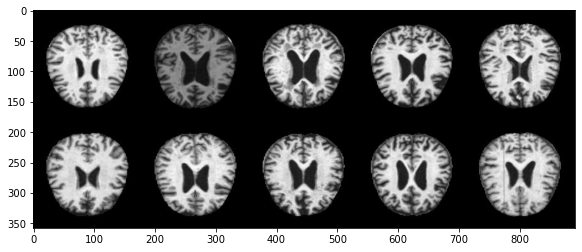

In [9]:
im = make_grid(images,nrow=5)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [58]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(42*42*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,42*42*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim = 1)
        

In [59]:
(((176-2)/2)-2)/2

42.5

In [60]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.001)

In [61]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=28224, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [62]:
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
3386880
120
10080
84
168
2


In [63]:
import time
start_time = time.time()

epochs = 10

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   10 [   100/8000]  loss: 0.71276981  accuracy:  54.000%
epoch:  0  batch:   20 [   200/8000]  loss: 0.59682381  accuracy:  56.500%
epoch:  0  batch:   30 [   300/8000]  loss: 0.55779296  accuracy:  56.333%
epoch:  0  batch:   40 [   400/8000]  loss: 0.67011958  accuracy:  59.000%
epoch:  0  batch:   50 [   500/8000]  loss: 0.59919876  accuracy:  58.200%
epoch:  0  batch:   60 [   600/8000]  loss: 0.72117198  accuracy:  58.000%
epoch:  0  batch:   70 [   700/8000]  loss: 0.65381622  accuracy:  57.571%
epoch:  0  batch:   80 [   800/8000]  loss: 0.65638888  accuracy:  57.375%
epoch:  1  batch:   10 [   100/8000]  loss: 0.63871181  accuracy:  57.000%
epoch:  1  batch:   20 [   200/8000]  loss: 0.67444861  accuracy:  59.500%
epoch:  1  batch:   30 [   300/8000]  loss: 0.52276945  accuracy:  64.000%
epoch:  1  batch:   40 [   400/8000]  loss: 0.60034955  accuracy:  63.500%
epoch:  1  batch:   50 [   500/8000]  loss: 0.65702283  accuracy:  63.200%
epoch:  1  batch:   60 [ 

In [64]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

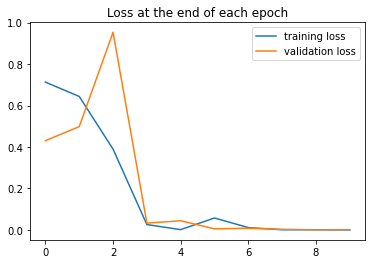

In [65]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

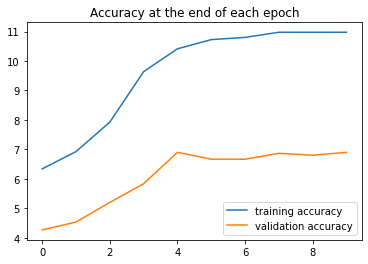

In [66]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();